# NB 03: Lab Fitness vs Field Abundance

Test whether lab-measured fitness under contaminant stress predicts
field abundance of Fitness Browser organisms at Oak Ridge sites.

**Run locally** — uses extracted ENIGMA data + cached FB data.

**Outputs**: 3 figures, correlation tests.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['savefig.bbox'] = 'tight'

DATA_DIR = Path('../data')
FIG_DIR = Path('../figures')
FIG_DIR.mkdir(exist_ok=True)

## 1. Load Data

In [2]:
# Genus abundance (long format)
genus_counts = pd.read_csv(DATA_DIR / 'genus_counts.tsv', sep='\t')
print(f"Genus counts: {len(genus_counts):,} rows")

# Geochemistry
geochem = pd.read_csv(DATA_DIR / 'site_geochemistry.tsv', sep='\t', index_col=0)
print(f"Geochemistry: {len(geochem)} samples x {geochem.shape[1]} molecules")

# FB genus mapping
fb_genera = pd.read_csv(DATA_DIR / 'fb_genus_mapping.tsv', sep='\t')
print(f"FB genera detected: {len(fb_genera)}")

# FB fitness by condition type
fitness_cond = pd.read_csv(
    '../../fitness_effects_conservation/data/fitness_stats_by_condition.tsv',
    sep='\t'
)
print(f"Fitness by condition: {len(fitness_cond):,} rows")

# FB organism mapping
org_map = pd.read_csv(
    '../../conservation_vs_fitness/data/organism_mapping.tsv',
    sep='\t'
)[['orgId', 'genus']].drop_duplicates()

Genus counts: 27,893 rows
Geochemistry: 108 samples x 48 molecules
FB genera detected: 14


Fitness by condition: 961,036 rows


## 2. Per-Genus Correlation with Uranium

For each FB genus detected at Oak Ridge, correlate its relative
abundance with uranium concentration across sites.

In [3]:
# Build per-sample genus abundance for FB genera
from statsmodels.stats.multitest import multipletests

fb_genus_list = fb_genera['genus'].tolist()

# Get uranium concentration per sample
uranium_col = 'uranium' if 'uranium' in geochem.columns else None
if uranium_col is None:
    print("ERROR: No uranium column found")
else:
    uranium = geochem[uranium_col].copy()
    print(f"Uranium concentration: min={uranium.min():.3f}, median={uranium.median():.3f}, max={uranium.max():.1f} uM")

# For each FB genus, compute correlation with uranium
corr_results = []
for genus in fb_genus_list:
    # Get abundance per sample for this genus
    genus_data = genus_counts[genus_counts['genus'] == genus]
    genus_by_sample = genus_data.groupby('sdt_sample_name')['rel_abundance'].sum()
    
    # Align with uranium data
    common_samples = list(set(genus_by_sample.index) & set(uranium.index))
    if len(common_samples) < 10:
        continue
    
    abund = genus_by_sample.reindex(uranium.index, fill_value=0)
    
    # Spearman correlation
    rho, pval = stats.spearmanr(uranium, abund)
    
    corr_results.append({
        'genus': genus,
        'n_sites_detected': (abund > 0).sum(),
        'mean_abundance': abund[abund > 0].mean() * 100 if (abund > 0).sum() > 0 else 0,
        'spearman_rho': rho,
        'p_value': pval,
    })

corr_df = pd.DataFrame(corr_results).sort_values('spearman_rho', ascending=False)

# BH-FDR correction for multiple testing
_, corr_df['fdr'], _, _ = multipletests(corr_df['p_value'], method='fdr_bh')
corr_df['significant'] = corr_df['fdr'] < 0.05

n_tested = len(corr_df)
n_excluded = len(fb_genus_list) - n_tested
n_sig = corr_df['significant'].sum()

print(f"\nFB genus abundance vs uranium (Spearman, BH-FDR corrected):")
print(f"  Tested: {n_tested} genera (excluded {n_excluded} with <10 sites detected)")
print(f"  Significant (FDR<0.05): {n_sig}")
print()
print(corr_df.to_string(index=False))

Uranium concentration: min=0.000, median=0.005, max=188.2 uM

FB genus abundance vs uranium (Spearman, BH-FDR corrected):
  Tested: 11 genera (excluded 3 with <10 sites detected)
  Significant (FDR<0.05): 5

         genus  n_sites_detected  mean_abundance  spearman_rho  p_value      fdr  significant
Herbaspirillum                16        0.414122      0.336143 0.000375 0.001377         True
   Bacteroides                14        1.492475      0.263881 0.005789 0.012736         True
  Azospirillum                26        0.174136      0.196256 0.041785 0.076605        False
     Ralstonia                15        0.210572      0.183455 0.057368 0.090149        False
        Dyella                16        0.256532      0.045826 0.637682 0.701451        False
 Desulfovibrio                49        0.347853      0.022420 0.817851 0.817851        False
   Pseudomonas                98        1.667397     -0.058732 0.545990 0.667321        False
   Cupriavidus                83        

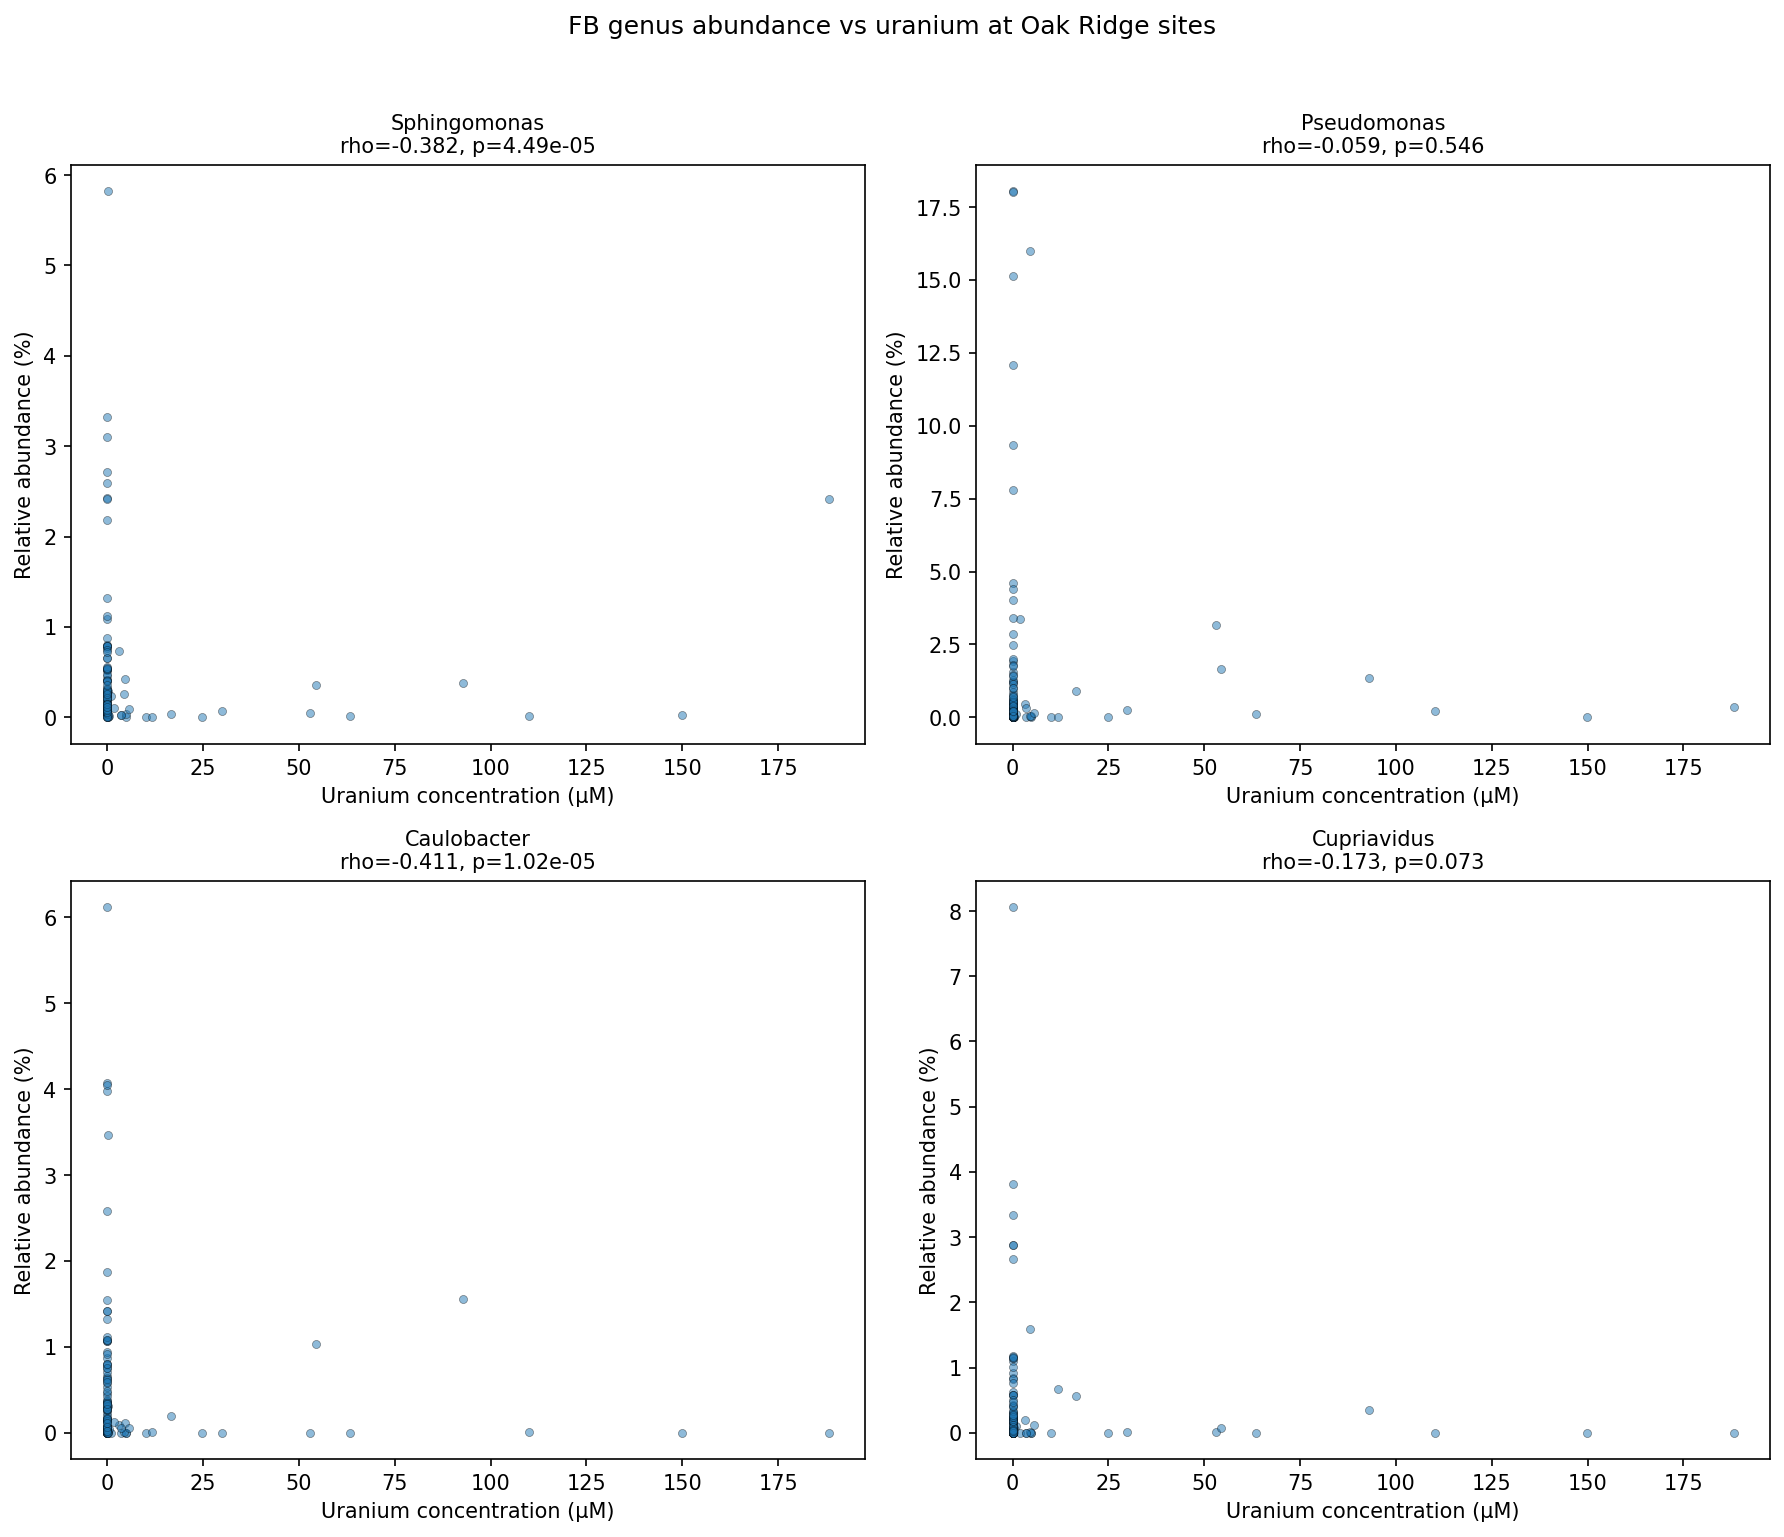

In [4]:
# Figure 1: Scatter plots of genus abundance vs uranium for top genera
# Show the 4 most prevalent FB genera
top_genera = fb_genera.nlargest(4, 'prevalence')['genus'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, genus in enumerate(top_genera):
    ax = axes[i]
    genus_data = genus_counts[genus_counts['genus'] == genus]
    genus_by_sample = genus_data.groupby('sdt_sample_name')['rel_abundance'].sum()
    abund = genus_by_sample.reindex(uranium.index, fill_value=0)
    
    ax.scatter(uranium, abund * 100, alpha=0.5, s=15, edgecolor='black', linewidth=0.3)
    
    # Add correlation info
    row = corr_df[corr_df['genus'] == genus]
    if len(row) > 0:
        rho = row.iloc[0]['spearman_rho']
        pval = row.iloc[0]['p_value']
        ax.set_title(f"{genus}\nrho={rho:.3f}, p={pval:.3g}", fontsize=10)
    else:
        ax.set_title(genus, fontsize=10)
    
    ax.set_xlabel('Uranium concentration (µM)')
    ax.set_ylabel('Relative abundance (%)')

plt.suptitle('FB genus abundance vs uranium at Oak Ridge sites', fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig(FIG_DIR / 'fig_abundance_vs_uranium.png')
plt.show()

## 3. Metal Tolerance Score vs Field Abundance

For each FB organism, compute a "metal tolerance score" from stress
condition fitness, then test if tolerant organisms are more abundant
at contaminated sites.

In [5]:
# Compute mean fitness under stress conditions per organism
# Use mean_fit (average fitness effect) as the tolerance metric:
# more negative = more genes are important = less tolerant
# near zero = genes are dispensable under stress = more tolerant
stress_fitness = fitness_cond[fitness_cond['expGroup'] == 'stress'].copy()
org_stress = stress_fitness.groupby('orgId').agg(
    mean_stress_fit=('mean_fit', 'mean'),
    n_stress_genes=('locusId', 'count'),
).reset_index()

# Add genus
org_stress = org_stress.merge(org_map, on='orgId', how='left')

# Metal tolerance = mean fitness under stress (closer to 0 = more tolerant,
# more negative = more genes matter for stress survival = less tolerant)
# Invert sign so higher = more tolerant
org_stress['metal_tolerance'] = -org_stress['mean_stress_fit']

print("FB organism stress tolerance (higher = more tolerant):")
print(org_stress[['orgId', 'genus', 'n_stress_genes', 'mean_stress_fit', 'metal_tolerance']]
      .sort_values('metal_tolerance', ascending=False).head(15).to_string(index=False))

FB organism stress tolerance (higher = more tolerant):
           orgId          genus  n_stress_genes  mean_stress_fit  metal_tolerance
Methanococcus_S2  Methanococcus            1244        -0.464841         0.464841
              PS   Dechlorosoma            2561        -0.400671         0.400671
            SynE  Synechococcus            1899        -0.265389         0.265389
             MR1     Shewanella            3782        -0.095037         0.095037
          Btheta    Bacteroides            4055        -0.086244         0.086244
         HerbieS Herbaspirillum            3879        -0.073590         0.073590
           Ponti    Pontibacter            3685        -0.072236         0.072236
         Pedo557     Pedobacter            4423        -0.068688         0.068688
          Putida    Pseudomonas            4778        -0.068107         0.068107
          psRCH2    Pseudomonas            3349        -0.067645         0.067645
          azobra   Azospirillum            

In [6]:
# Classify sites as high-uranium vs low-uranium
median_u = uranium.median()
high_u_samples = uranium[uranium > median_u].index.tolist()
low_u_samples = uranium[uranium <= median_u].index.tolist()
print(f"High-uranium sites (> {median_u:.3f} µM): {len(high_u_samples)}")
print(f"Low-uranium sites: {len(low_u_samples)}")

# For each FB genus, compute mean abundance at high vs low uranium sites
genus_by_uranium = []
for genus in fb_genus_list:
    genus_data = genus_counts[genus_counts['genus'] == genus]
    genus_by_sample = genus_data.groupby('sdt_sample_name')['rel_abundance'].sum()
    
    high_abund = genus_by_sample.reindex(high_u_samples, fill_value=0).mean() * 100
    low_abund = genus_by_sample.reindex(low_u_samples, fill_value=0).mean() * 100
    
    # Get metal tolerance for this genus (average across FB organisms)
    genus_tolerance = org_stress[org_stress['genus'] == genus]['metal_tolerance'].mean()
    
    genus_by_uranium.append({
        'genus': genus,
        'high_u_abundance': high_abund,
        'low_u_abundance': low_abund,
        'abundance_ratio': high_abund / low_abund if low_abund > 0 else np.nan,
        'metal_tolerance': genus_tolerance,
    })

gu_df = pd.DataFrame(genus_by_uranium).dropna()
print("\nFB genus abundance at high vs low uranium sites:")
print(gu_df.sort_values('abundance_ratio', ascending=False).to_string(index=False))

# Correlate metal tolerance score with abundance ratio
if len(gu_df) >= 5:
    rho, pval = stats.spearmanr(gu_df['metal_tolerance'], gu_df['abundance_ratio'])
    print(f"\nMetal tolerance vs high-U abundance ratio: rho={rho:.3f}, p={pval:.3g}")

High-uranium sites (> 0.005 µM): 54
Low-uranium sites: 54

FB genus abundance at high vs low uranium sites:
         genus  high_u_abundance  low_u_abundance  abundance_ratio  metal_tolerance
   Bacteroides          0.385782         0.001156       333.818783         0.086244
Herbaspirillum          0.121506         0.001197       101.495141         0.073590
  Azospirillum          0.078476         0.005367        14.621696         0.061769
    Shewanella          0.000553         0.000415         1.334900         0.066287
  Sphingomonas          0.486429         0.516388         0.941985         0.047241
    Pedobacter          0.182992         0.196146         0.932938         0.068688
   Pseudomonas          1.412818         1.613198         0.875787         0.046710
   Cupriavidus          0.323544         0.558022         0.579805         0.045907
 Desulfovibrio          0.112037         0.203607         0.550262         0.060373
   Caulobacter          0.366405         0.753839   

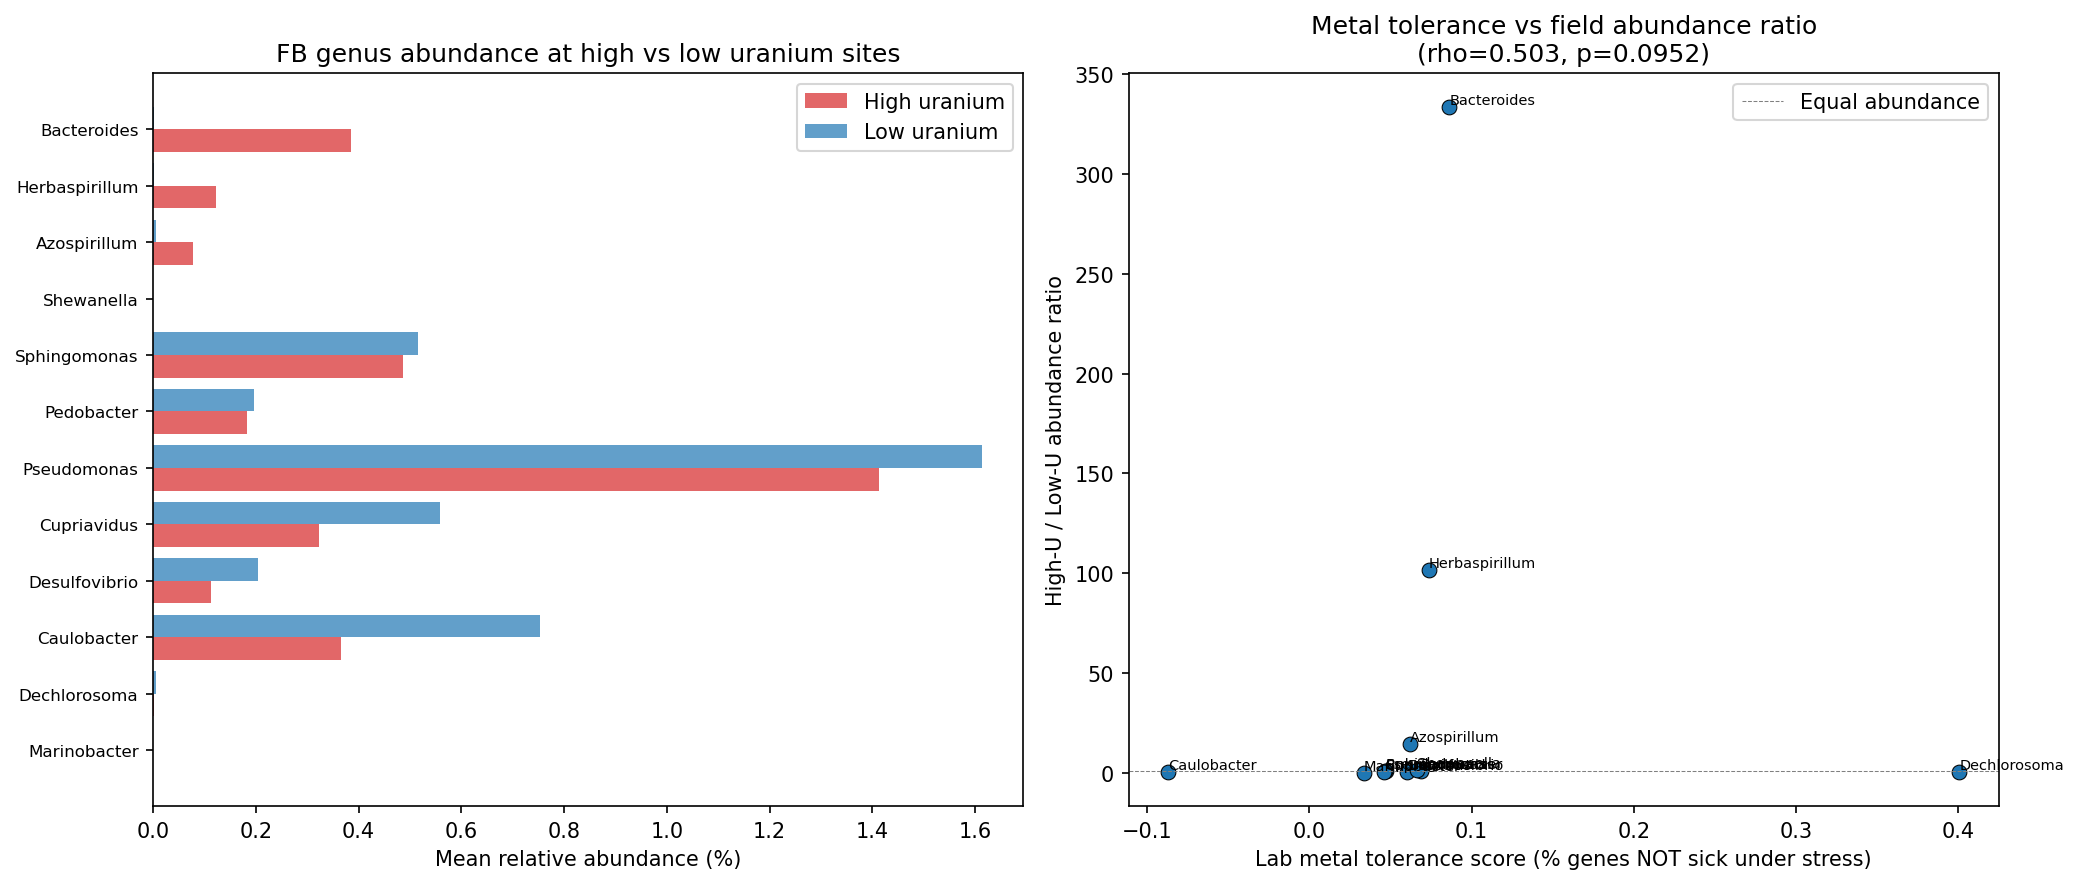

In [7]:
# Figure 2: Metal tolerance vs field abundance
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel A: High-U vs Low-U abundance for each FB genus
ax = axes[0]
plot_df = gu_df.sort_values('abundance_ratio', ascending=True)
y_pos = range(len(plot_df))
ax.barh(y_pos, plot_df['high_u_abundance'], height=0.4, label='High uranium', color='#d62728', alpha=0.7)
ax.barh([y + 0.4 for y in y_pos], plot_df['low_u_abundance'], height=0.4, label='Low uranium', color='#1f77b4', alpha=0.7)
ax.set_yticks([y + 0.2 for y in y_pos])
ax.set_yticklabels(plot_df['genus'], fontsize=8)
ax.set_xlabel('Mean relative abundance (%)')
ax.set_title('FB genus abundance at high vs low uranium sites')
ax.legend()

# Panel B: Metal tolerance score vs abundance ratio
ax = axes[1]
ax.scatter(gu_df['metal_tolerance'], gu_df['abundance_ratio'],
           s=50, edgecolor='black', linewidth=0.5)
for _, row in gu_df.iterrows():
    ax.annotate(row['genus'], (row['metal_tolerance'], row['abundance_ratio']),
                fontsize=7, ha='left', va='bottom')
ax.axhline(1.0, color='gray', linestyle='--', linewidth=0.5, label='Equal abundance')
ax.set_xlabel('Lab metal tolerance score (% genes NOT sick under stress)')
ax.set_ylabel('High-U / Low-U abundance ratio')
if len(gu_df) >= 5:
    ax.set_title(f'Metal tolerance vs field abundance ratio\n(rho={rho:.3f}, p={pval:.3g})')
else:
    ax.set_title('Metal tolerance vs field abundance ratio')
ax.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / 'fig_metal_tolerance_score.png')
plt.show()

## 4. Community Composition at High vs Low Uranium Sites

In [8]:
# Compare top genera at high vs low uranium sites
# Aggregate genus counts for high and low uranium
high_u_counts = genus_counts[genus_counts['sdt_sample_name'].isin(high_u_samples)]
low_u_counts = genus_counts[genus_counts['sdt_sample_name'].isin(low_u_samples)]

high_u_genus = high_u_counts.groupby('genus')['rel_abundance'].mean().sort_values(ascending=False)
low_u_genus = low_u_counts.groupby('genus')['rel_abundance'].mean().sort_values(ascending=False)

# Top 20 genera by abundance at high-U sites
print("Top 20 genera at high-uranium sites:")
for i, (g, a) in enumerate(high_u_genus.head(20).items()):
    low_a = low_u_genus.get(g, 0)
    fb_tag = " [FB]" if g in fb_genus_list else ""
    print(f"  {i+1:2d}. {g:30s} {a*100:6.2f}% (low-U: {low_a*100:6.2f}%){fb_tag}")

Top 20 genera at high-uranium sites:
   1. uncultured                      11.01% (low-U:  14.91%)
   2. Candidatus_Omnitrophus           8.14% (low-U:   3.60%)
   3. Anoxybacillus                    6.46% (low-U:   0.01%)
   4. Rhodanobacter                    6.29% (low-U:   0.21%)
   5. Chujaibacter                     5.19% (low-U:   0.01%)
   6. BSV26                            3.68% (low-U:   1.72%)
   7. Dethiobacter                     3.14% (low-U:   0.67%)
   8. Carnobacterium                   3.04% (low-U:   0.01%)
   9. Brevundimonas                    2.63% (low-U:   3.36%)
  10. Ignavibacterium                  2.59% (low-U:   0.07%)
  11. Ferritrophicum                   2.54% (low-U:   0.46%)
  12. Sphingopyxis                     2.48% (low-U:   0.23%)
  13. Sideroxydans                     2.03% (low-U:   3.30%)
  14. WPS-2                            2.01% (low-U:   0.14%)
  15. Methylocystis                    1.96% (low-U:   1.66%)
  16. Bacteroides                

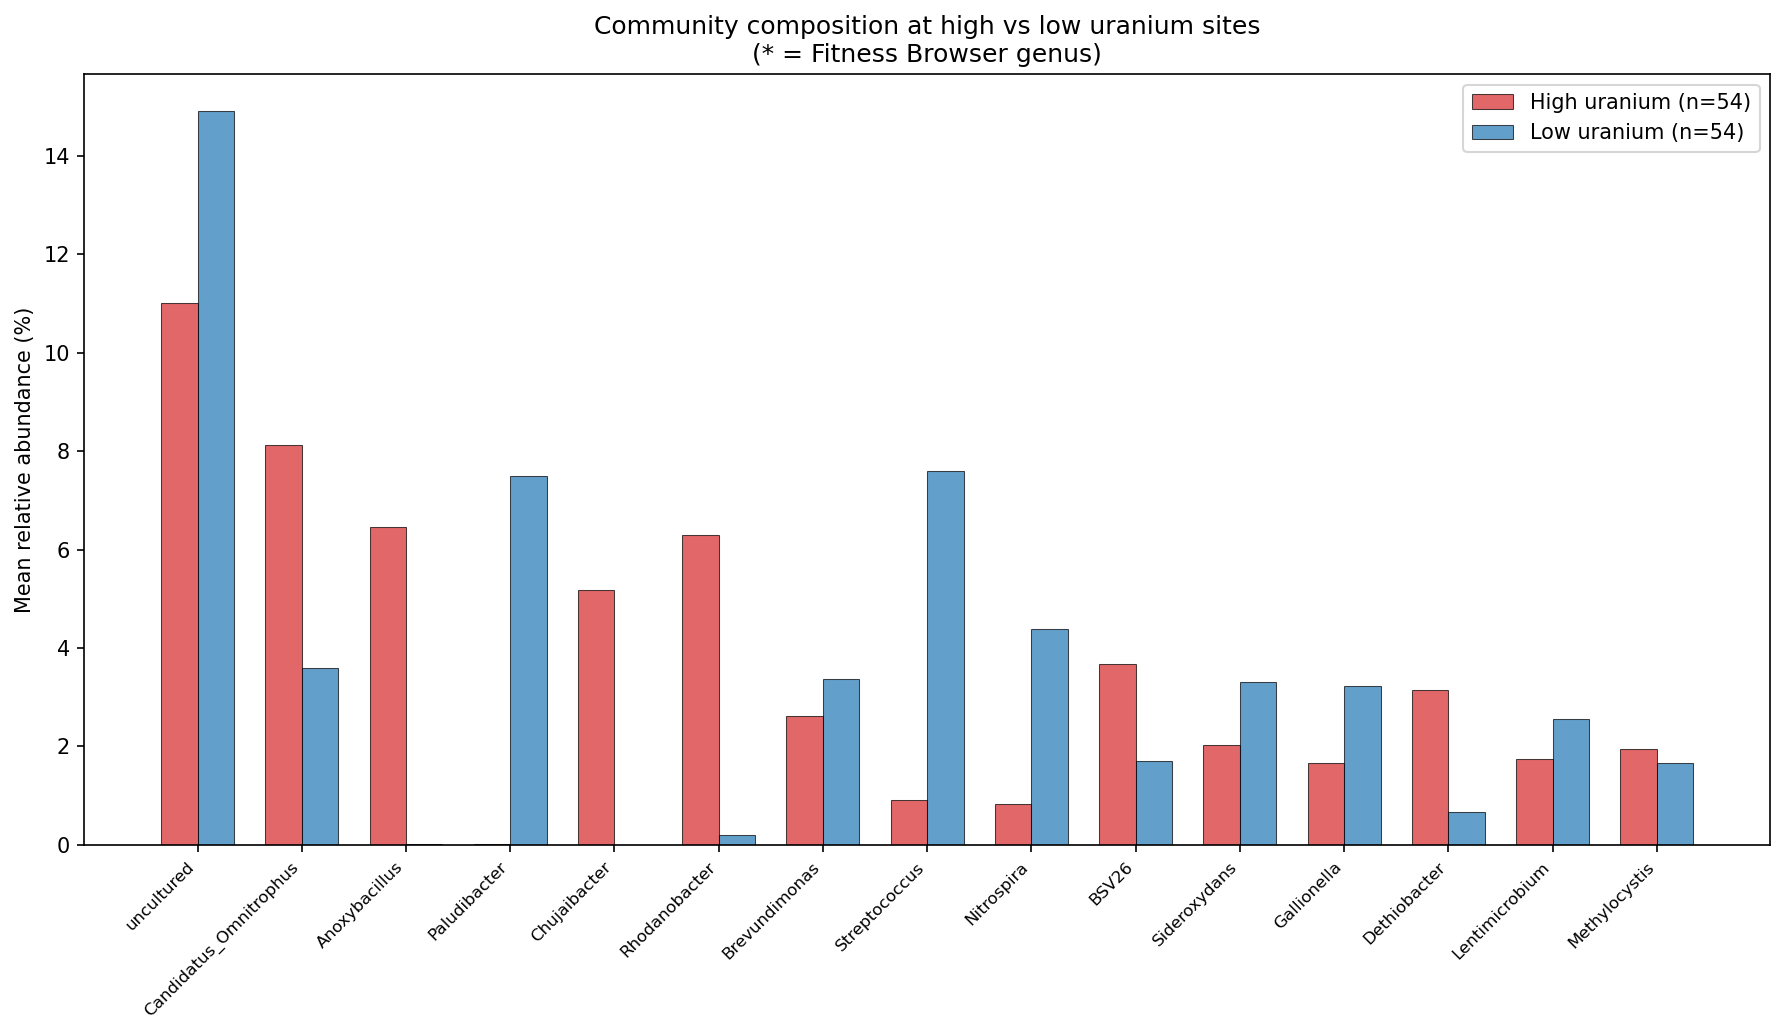

In [9]:
# Figure 3: Community composition at high vs low uranium sites
fig, ax = plt.subplots(figsize=(12, 7))

# Top 15 genera overall, show high-U vs low-U
all_genus = genus_counts.groupby('genus')['rel_abundance'].mean().sort_values(ascending=False)
top15 = all_genus.head(15).index.tolist()

high_vals = [high_u_genus.get(g, 0) * 100 for g in top15]
low_vals = [low_u_genus.get(g, 0) * 100 for g in top15]

x = np.arange(len(top15))
width = 0.35

bars1 = ax.bar(x - width/2, high_vals, width, label=f'High uranium (n={len(high_u_samples)})',
               color='#d62728', alpha=0.7, edgecolor='black', linewidth=0.5)
bars2 = ax.bar(x + width/2, low_vals, width, label=f'Low uranium (n={len(low_u_samples)})',
               color='#1f77b4', alpha=0.7, edgecolor='black', linewidth=0.5)

# Mark FB genera
for i, g in enumerate(top15):
    if g in fb_genus_list:
        ax.annotate('*', (i, max(high_vals[i], low_vals[i]) + 0.1),
                    ha='center', fontsize=14, color='green', fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(top15, rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Mean relative abundance (%)')
ax.set_title('Community composition at high vs low uranium sites\n(* = Fitness Browser genus)')
ax.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / 'fig_community_by_contamination.png')
plt.show()

## 5. Summary

In [10]:
print("=" * 60)
print("NB03 SUMMARY: Lab Fitness vs Field Abundance")
print("=" * 60)
print()
print(f"Sites analyzed: {len(geochem)} ({len(high_u_samples)} high-U, {len(low_u_samples)} low-U)")
print(f"FB genera tested: {n_tested} (excluded {n_excluded} with <10 sites)")
print()
print("Per-genus abundance vs uranium (Spearman, BH-FDR corrected):")
for _, row in corr_df.iterrows():
    sig = '*' if row['significant'] else ''
    print(f"  {row['genus']:20s}: rho={row['spearman_rho']:.3f}, p={row['p_value']:.3g}, q={row['fdr']:.3g} {sig}")
print()
print(f"Significant after FDR correction: {n_sig} / {n_tested}")
if len(gu_df) >= 5:
    print(f"Metal tolerance vs high-U abundance ratio: rho={rho:.3f}, p={pval:.3g}")
print("=" * 60)

NB03 SUMMARY: Lab Fitness vs Field Abundance

Sites analyzed: 108 (54 high-U, 54 low-U)
FB genera tested: 11 (excluded 3 with <10 sites)

Per-genus abundance vs uranium (Spearman, BH-FDR corrected):
  Herbaspirillum      : rho=0.336, p=0.000375, q=0.00138 *
  Bacteroides         : rho=0.264, p=0.00579, q=0.0127 *
  Azospirillum        : rho=0.196, p=0.0418, q=0.0766 
  Ralstonia           : rho=0.183, p=0.0574, q=0.0901 
  Dyella              : rho=0.046, p=0.638, q=0.701 
  Desulfovibrio       : rho=0.022, p=0.818, q=0.818 
  Pseudomonas         : rho=-0.059, p=0.546, q=0.667 
  Cupriavidus         : rho=-0.173, p=0.073, q=0.1 
  Pedobacter          : rho=-0.266, p=0.00535, q=0.0127 *
  Sphingomonas        : rho=-0.382, p=4.49e-05, q=0.000247 *
  Caulobacter         : rho=-0.411, p=1.02e-05, q=0.000112 *

Significant after FDR correction: 5 / 11
Metal tolerance vs high-U abundance ratio: rho=0.503, p=0.0952
